In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('..')

In [2]:
import models.cifar as models
checkpoint_paths = {}
checkpoint_paths['super'] = '/home/jdunnmon/Research/repos/pytorch-classification/checkpoints/cifar100/resnext-8x64d-epochs300-superclass'
checkpoint_paths['sub'] = '/home/jdunnmon/Research/repos/pytorch-classification/checkpoints/cifar100/resnext-8x64d-epochs300-pretrained'

In [3]:
from analysis.analysis_utils import load_trained_model, fetch_dataloaders
trained_models = {}
dataloaders = {}
ind_to_class = {}
class_to_ind = {}
for tp in ['super','sub']:
    trained_models[tp], args = load_trained_model(checkpoint_paths[tp])
    dataloaders[tp] = fetch_dataloaders(args)
    class_to_ind[tp] = dataloaders[tp]['test'].dataset.class_to_idx
    ind_to_class[tp] = {v:k for k,v in dataloaders[tp]['test'].dataset.class_to_idx.items()}

/home/jdunnmon/Research/repos/pytorch-classification/models/cifar/resnext.py:81: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.classifier.weight)
/home/jdunnmon/Research/repos/pytorch-classification/models/cifar/resnext.py:86: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


Using 20 classes...
Files already downloaded and verified
Using coarse labels...
Using coarse labels...
Using 100 classes...
Files already downloaded and verified
Using fine labels...
Using fine labels...


In [5]:
import torch

use_cuda = True
outputs = []
testloader = dataloaders['sub']['test']
model = trained_models['sub']
model.eval()
if use_cuda:
    trained_models['super'].cuda()
    trained_models['sub'].cuda()

In [6]:
filenames_all = []
coarse_labels_all = []
fine_labels_all = []
fine_preds_all = []
coarse_preds_all = []

for batch_idx, (inputs, targets, coarse_labels, fine_labels, filenames) in enumerate(testloader):

    if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

    # compute output
    preds = {}
    for tp in ['super','sub']:
        outputs = trained_models[tp](inputs)
        _, preds[tp] = outputs.topk(1, 1, True, True)
    
    coarse_labels_all+=list([int(a) for a in coarse_labels])
    fine_labels_all+=list([int(a) for a in fine_labels])
    coarse_preds_all+=list([int(a) for a in preds['super']])
    fine_preds_all+=list([int(a) for a in preds['sub']])
    filenames_all+=list(filenames)

/home/jdunnmon/Research/repos/anaconda3/envs/pytorch-classification/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


In [15]:
import pandas as pd
prediction_df = pd.DataFrame({
    'filename':filenames_all,
    'fine_labels':fine_labels_all,
    'coarse_labels':coarse_labels_all,
    'fine_preds':fine_preds_all,
    'coarse_preds':coarse_preds_all,
    'fine_labels_string': [ind_to_class['sub'][a] for a in fine_labels_all],
    'coarse_labels_string': [ind_to_class['super'][a] for a in coarse_labels_all]
})

In [30]:
prediction_df
prediction_df.to_csv('predictions.csv')

In [41]:
from collections import Counter
Counter(prediction_df[prediction_df['coarse_labels_string']=='aquatic_mammals']['fine_labels_string'])

Counter({'seal': 100,
         'beaver': 100,
         'whale': 100,
         'dolphin': 100,
         'otter': 100})

In [57]:
from sklearn.metrics import accuracy_score
from collections import defaultdict
coarse_results = defaultdict(dict)
accuracy_type = 'coarse'
for coarse_class in prediction_df['coarse_labels_string'].unique():
    coarse_accs = {}
    coarse_class_df = prediction_df[prediction_df['coarse_labels_string']==coarse_class]
    coarse_class_acc = accuracy_score(coarse_class_df[f'{accuracy_type}_labels'],coarse_class_df[f'{accuracy_type}_preds'])
    print(f'{coarse_class} superclass {accuracy_type} label accuracy: {coarse_class_acc}')
    coarse_results['superclass'].update({coarse_class:coarse_class_acc})
   # print(f"fine label disribution: {Counter(coarse_class_df['fine_labels_string'])}")
    for ii, fine_class in enumerate(coarse_class_df['fine_labels_string'].unique()):
        fine_class_df = coarse_class_df[coarse_class_df['fine_labels_string']==fine_class]
        fine_class_acc = accuracy_score(fine_class_df[f'{accuracy_type}_labels'],fine_class_df[f'{accuracy_type}_preds'])
        print(f'{fine_class} subclass {accuracy_type} label accuracy: {fine_class_acc}')
        coarse_results[f'subclass_{ii}'].update({coarse_class:fine_class_acc})
    print('\n')

large_natural_outdoor_scenes superclass coarse label accuracy: 0.88
mountain subclass coarse label accuracy: 0.89
forest subclass coarse label accuracy: 0.66
sea subclass coarse label accuracy: 0.95
cloud subclass coarse label accuracy: 0.95
plain subclass coarse label accuracy: 0.95


aquatic_mammals superclass coarse label accuracy: 0.736
seal subclass coarse label accuracy: 0.65
beaver subclass coarse label accuracy: 0.68
whale subclass coarse label accuracy: 0.84
dolphin subclass coarse label accuracy: 0.82
otter subclass coarse label accuracy: 0.69


fruit_and_vegetables superclass coarse label accuracy: 0.872
mushroom subclass coarse label accuracy: 0.68
apple subclass coarse label accuracy: 0.98
orange subclass coarse label accuracy: 0.99
pear subclass coarse label accuracy: 0.86
sweet_pepper subclass coarse label accuracy: 0.85


flowers superclass coarse label accuracy: 0.93
tulip subclass coarse label accuracy: 0.96
rose subclass coarse label accuracy: 0.93
sunflower subclass

In [99]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(15,15))
plot_df = pd.DataFrame(coarse_results).reset_index()
plot_df = plot_df.rename(columns={"index": "Superclass"})
plot_df = plot_df.melt(id_vars=['Superclass'], var_name='Subset', value_name='Accuracy')

<Figure size 1080x1080 with 0 Axes>

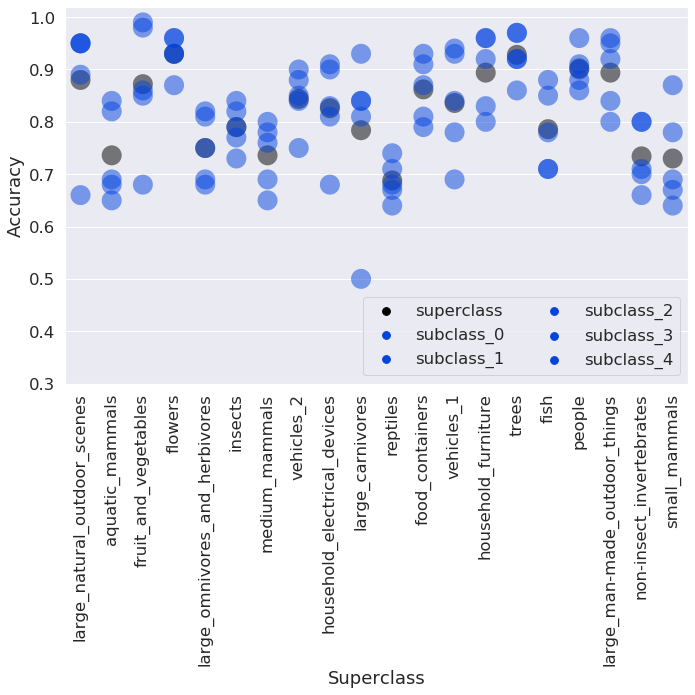

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
palette = [sns.xkcd_rgb["black"]] + 5*[sns.xkcd_rgb["blue"]]
sns.set(font_scale=1.5)
f = plt.figure(figsize=(10,10))
ax = sns.stripplot(x="Superclass", y="Accuracy", hue="Subset", data=plot_df, jitter=False, s=20, palette=palette, alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
h,l = ax.get_legend_handles_labels()
ax.legend_.remove()
ax.legend(h,l, ncol=2, loc='lower right')
ax.set_ylim([0.3,1.02])
plt.tight_layout()
plt.savefig('Superclass-Subclass-CIFAR-100.png',format='png')

## SANDBOX

In [43]:
print([ind_to_class['super'][a] for a in dataloaders['super']['test'].dataset.data['coarse_labels']][0:5])
print([ind_to_class['sub'][a] for a in dataloaders['sub']['test'].dataset.data['fine_labels']][0:5])

['large_omnivores_and_herbivores', 'reptiles', 'fruit_and_vegetables', 'people', 'fish']
['cattle', 'dinosaur', 'apple', 'boy', 'aquarium_fish']


In [38]:
ind_to_class['super']

{0: 'aquatic_mammals',
 1: 'fish',
 2: 'flowers',
 3: 'food_containers',
 4: 'fruit_and_vegetables',
 5: 'household_electrical_devices',
 6: 'household_furniture',
 7: 'insects',
 8: 'large_carnivores',
 9: 'large_man-made_outdoor_things',
 10: 'large_natural_outdoor_scenes',
 11: 'large_omnivores_and_herbivores',
 12: 'medium_mammals',
 13: 'non-insect_invertebrates',
 14: 'people',
 15: 'reptiles',
 16: 'small_mammals',
 17: 'trees',
 18: 'vehicles_1',
 19: 'vehicles_2'}

In [14]:
dataloaders['super']['test'].dataset[105]

{'fine_label': 93,
 'coarse_label': 15,
 'filename': 'turtle_s_000005.png',
 'target': 15,
 'img': tensor([[[-9.3643e-01,  1.6851e-01,  1.2974e-01,  ..., -8.7827e-01,
           -1.2660e+00, -1.3047e+00],
          [ 4.7867e-01,  5.7560e-01,  1.1036e-01,  ..., -4.7119e-01,
           -6.8442e-01, -4.7119e-01],
          [ 1.0990e+00,  4.9806e-01,  3.0421e-01,  ..., -4.4721e-02,
           -1.0288e-01,  1.6851e-01],
          ...,
          [ 1.6030e+00,  1.7775e+00,  1.8938e+00,  ...,  1.3510e+00,
            1.4673e+00,  1.5642e+00],
          [ 1.7581e+00,  1.9325e+00,  1.9713e+00,  ...,  1.6418e+00,
            1.5255e+00,  1.5642e+00],
          [ 1.6805e+00,  1.7387e+00,  1.7581e+00,  ...,  1.4867e+00,
            1.4091e+00,  1.6612e+00]],
 
         [[-1.2776e+00, -3.3357e-01, -4.1224e-01,  ..., -1.2579e+00,
           -1.6512e+00, -1.6906e+00],
          [ 7.6703e-04,  4.0101e-02, -4.1224e-01,  ..., -9.4324e-01,
           -1.1399e+00, -9.2357e-01],
          [ 5.1211e-01, -5.8

In [4]:
len(dataloaders['sub']['test'].dataset)

10000

In [53]:
import pickle
with open('data/cifar-100-python/test','rb') as fl:
    test_set = pickle.load(fl, encoding='latin1')

In [55]:
len(test_set['filenames'])

10000